# OS - ELM

Using device: cuda
Found 3 dataset files

COMPREHENSIVE OS-ELM TUNING FOR MEFAR_DOWN.csv
Dataset loaded: (27570, 18)
Handling missing values...
Features: 17, Samples: 27570
Classes: [0. 1.], Distribution: [13106 14464]
Training samples: 22056, Test samples: 5514

Configuration 1/11
Config: {'n_hidden': 100, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3}
Training strategy: 6616 initial, 15440 sequential
Initial training: 6616 samples, 17 features, 100 neurons
Hidden layer shape: torch.Size([6616, 100]), Target shape: torch.Size([6616, 1])
Initial training successful. Regularization: 0.010000
Output weights shape: torch.Size([100, 1])
Sequential training: 309 batches of size ≤50
Results:
  Train Accuracy: 66.11%
  Test Accuracy:  65.72%
  Training Time:  5.961s
  Overfitting:    0.39%

Configuration 2/11
Config: {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3}
Training strategy: 6616 initial, 15440 sequential
Initial training: 6616 

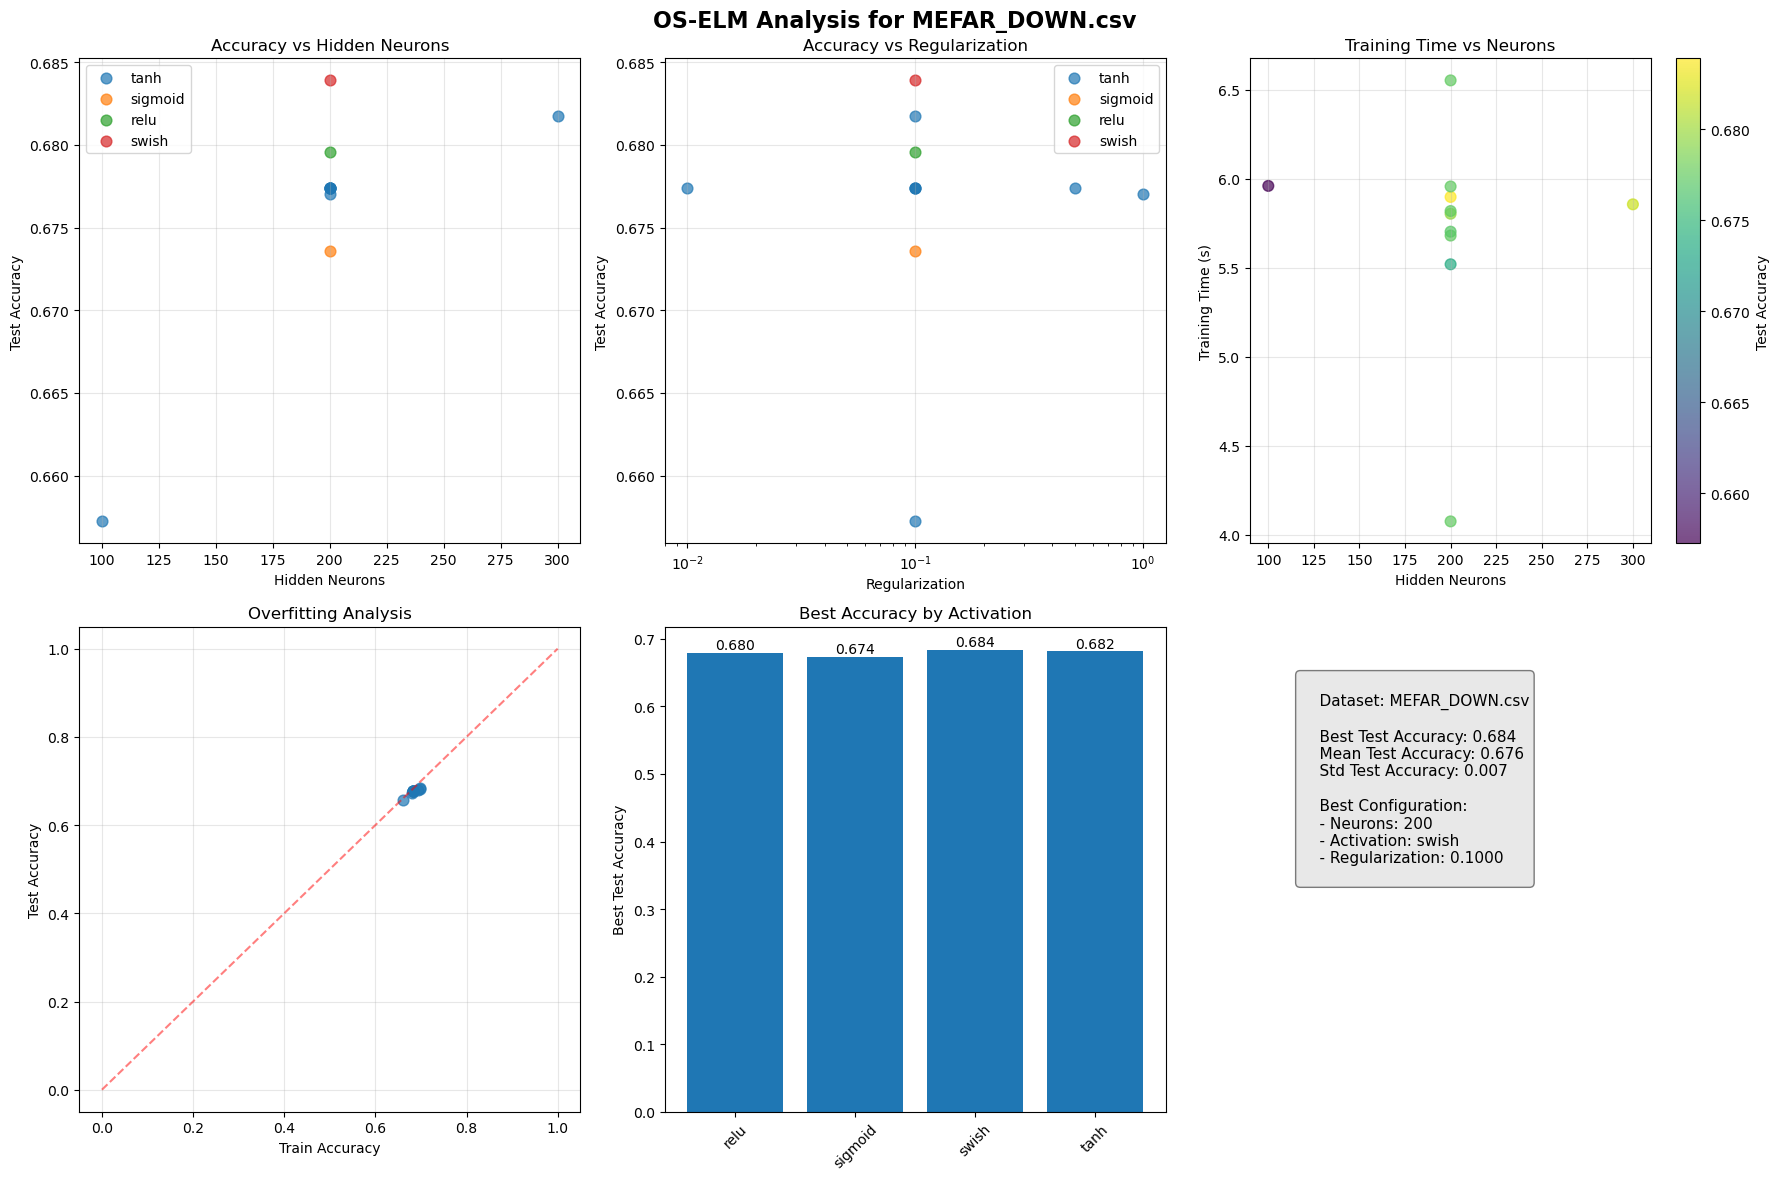


COMPREHENSIVE OS-ELM TUNING FOR MEFAR_MID.csv
Dataset loaded: (923298, 18)
Features: 17, Samples: 923298
Classes: [0. 1.], Distribution: [461649 461649]
Training samples: 738638, Test samples: 184660

Configuration 1/11
Config: {'n_hidden': 100, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3}
Training strategy: 221591 initial, 517047 sequential
Initial training: 221591 samples, 17 features, 100 neurons
Hidden layer shape: torch.Size([221591, 100]), Target shape: torch.Size([221591, 1])
Initial training successful. Regularization: 0.010000
Output weights shape: torch.Size([100, 1])
Sequential training: 10341 batches of size ≤50
Results:
  Train Accuracy: 66.15%
  Test Accuracy:  66.32%
  Training Time:  183.166s
  Overfitting:    -0.17%

Configuration 2/11
Config: {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3}
Training strategy: 221591 initial, 517047 sequential
Initial training: 221591 samples, 17 features, 200 neurons
Hidden la

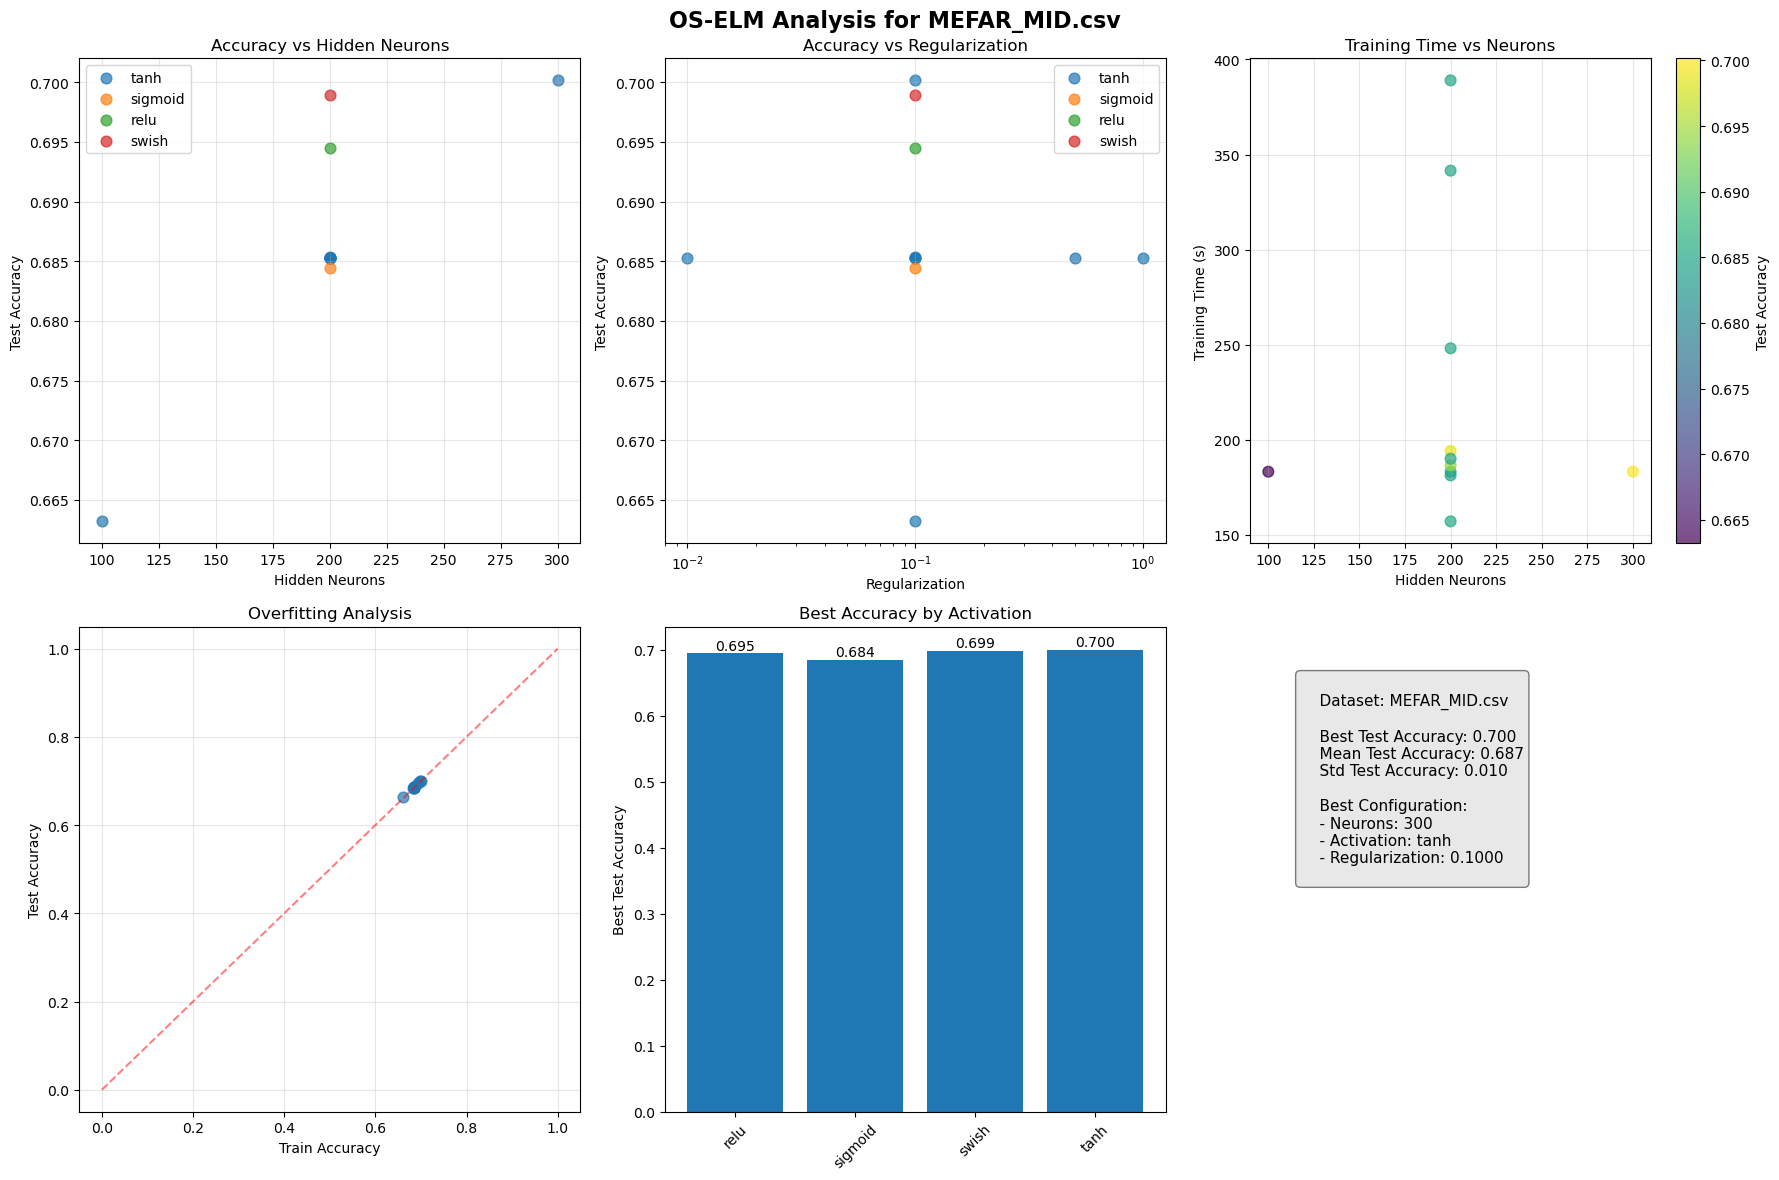


COMPREHENSIVE OS-ELM TUNING FOR MEFAR_UP.csv
Dataset loaded: (1846590, 18)
Features: 17, Samples: 1846590
Classes: [0. 1.], Distribution: [923295 923295]
Training samples: 1477272, Test samples: 369318

Configuration 1/11
Config: {'n_hidden': 100, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3}
Training strategy: 443181 initial, 1034091 sequential
Initial training: 443181 samples, 17 features, 100 neurons
Hidden layer shape: torch.Size([443181, 100]), Target shape: torch.Size([443181, 1])
Initial training successful. Regularization: 0.010000
Output weights shape: torch.Size([100, 1])
Sequential training: 20682 batches of size ≤50
Results:
  Train Accuracy: 66.20%
  Test Accuracy:  66.23%
  Training Time:  385.124s
  Overfitting:    -0.03%

Configuration 2/11
Config: {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3}
Training strategy: 443181 initial, 1034091 sequential
Initial training: 443181 samples, 17 features, 200 neurons
Hidde

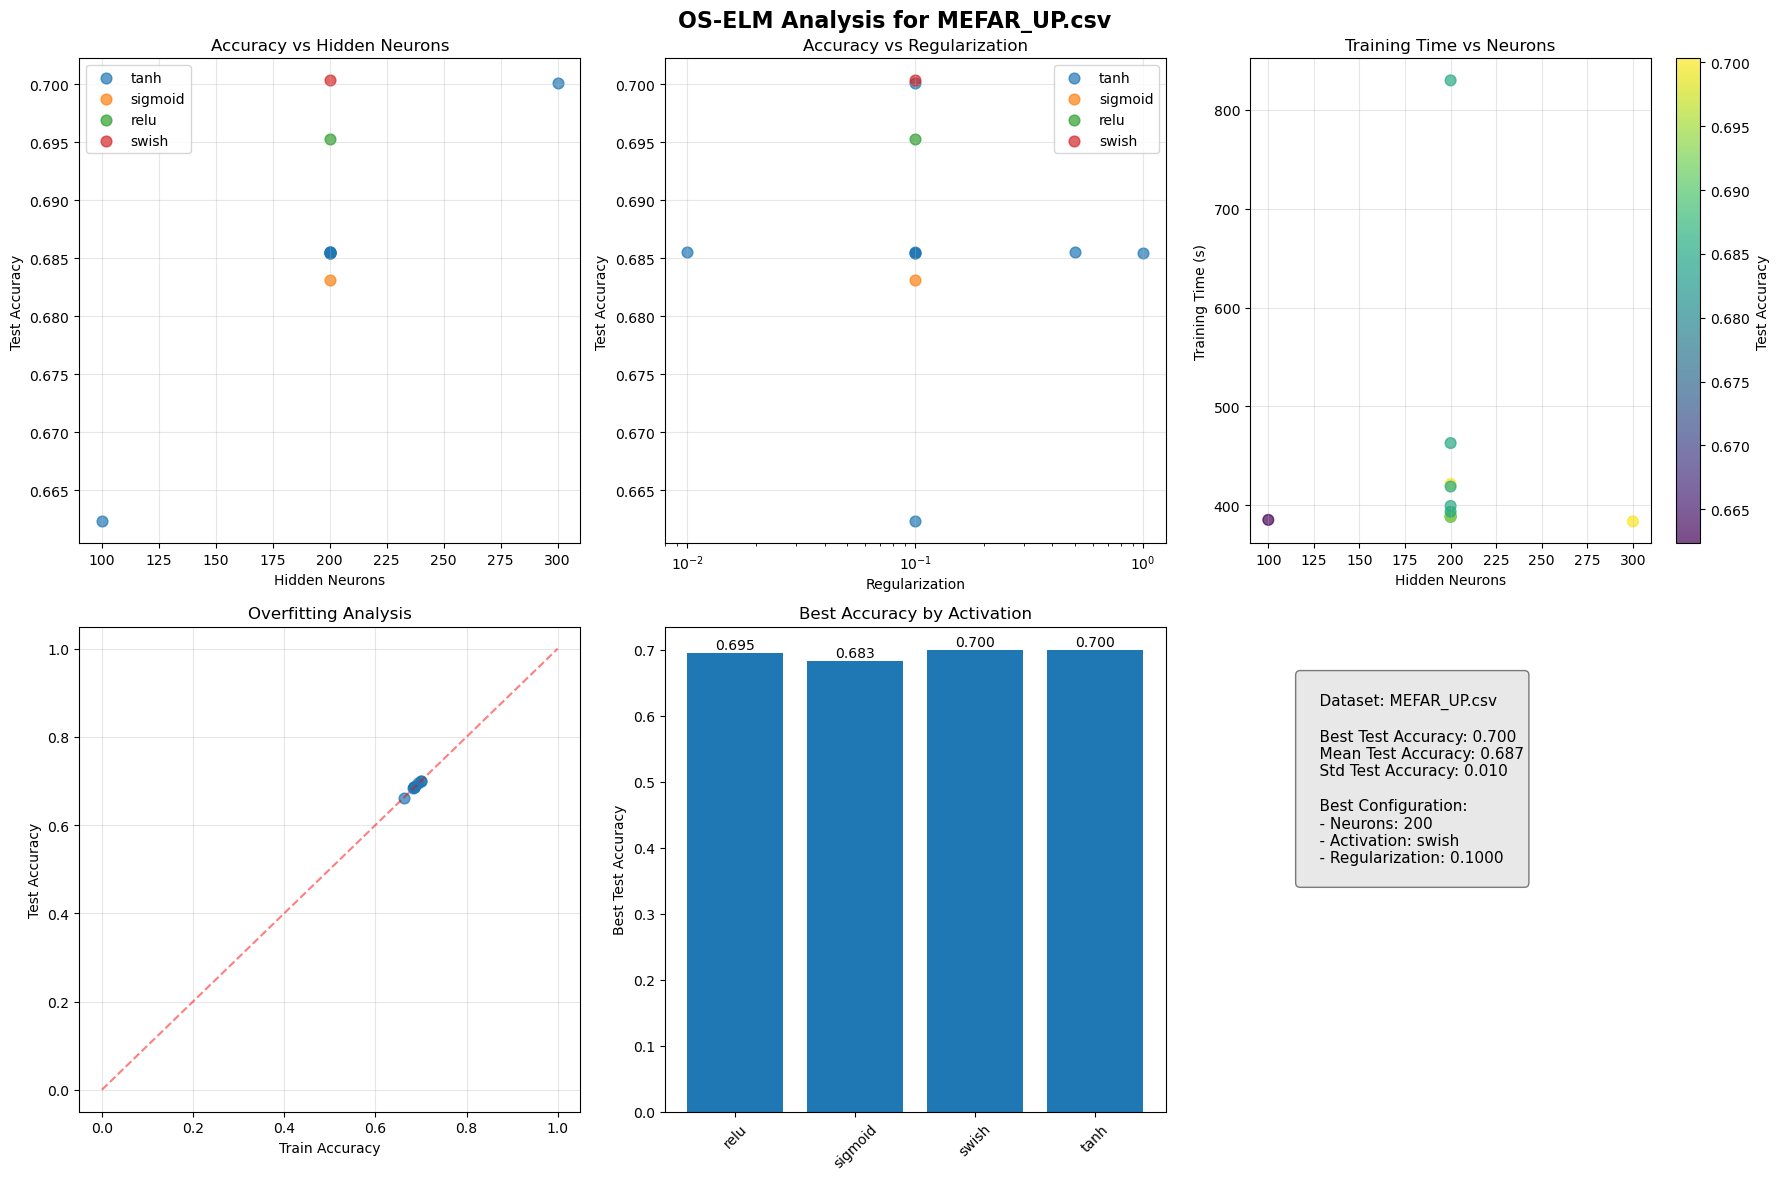


OVERALL SUMMARY ACROSS ALL DATASETS
MEFAR_DOWN.csv: Best accuracy = 68.39%
MEFAR_MID.csv: Best accuracy = 70.02%
MEFAR_UP.csv: Best accuracy = 70.03%

Comprehensive tuning completed!


In [2]:
import pandas as pd
import numpy as np
import time
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from typing import Optional, Union, List
import warnings
warnings.filterwarnings('ignore')

class RobustOSELM(nn.Module):
    """
    Robust Online Sequential Extreme Learning Machine with improved numerical stability.
    
    Features:
    - Proper hyperparameter ranges
    - Numerical stability improvements
    - Adaptive regularization
    - Better initialization strategies
    """
    
    def __init__(self, 
                 n_hidden: int = 200,
                 activation: str = 'tanh',
                 regularization: float = 0.1,
                 device: str = 'auto',
                 random_state: Optional[int] = None,
                 adaptive_reg: bool = True):
        super(RobustOSELM, self).__init__()
        
        self.n_hidden = n_hidden
        self.activation = activation
        self.regularization = regularization
        self.adaptive_reg = adaptive_reg
        self.random_state = random_state
        
        # Set device
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        # Model parameters
        self.input_weights = None
        self.biases = None
        self.output_weights = None
        self.P_matrix = None  # Precision matrix for online updates
        self.n_features = None
        self.n_classes = None
        self.classes_ = None
        self.is_fitted = False
        self.sample_count = 0
        
        # Set random seed for reproducibility
        if random_state is not None:
            torch.manual_seed(random_state)
            np.random.seed(random_state)
    
    def _get_activation_function(self):
        """Get activation function with improved options."""
        if self.activation == 'sigmoid':
            return lambda x: torch.sigmoid(x)
        elif self.activation == 'tanh':
            return lambda x: torch.tanh(x)
        elif self.activation == 'relu':
            return lambda x: torch.relu(x)
        elif self.activation == 'leaky_relu':
            return lambda x: torch.leaky_relu(x, 0.01)
        elif self.activation == 'swish':
            return lambda x: x * torch.sigmoid(x)
        else:
            return lambda x: torch.tanh(x)  # Default fallback
    
    def _initialize_network(self, n_features):
        """Initialize network with proper scaling."""
        self.n_features = n_features
        
        # Xavier/Glorot initialization for better convergence
        if self.activation in ['sigmoid', 'tanh']:
            # Xavier uniform initialization
            limit = np.sqrt(6.0 / (n_features + self.n_hidden))
            # FIX: Use torch.rand() and scale to [-limit, limit]
            self.input_weights = (torch.rand(self.n_hidden, n_features, device=self.device) * 2 * limit) - limit
        else:
            # He initialization for ReLU-like activations
            std = np.sqrt(2.0 / n_features)
            self.input_weights = torch.randn(self.n_hidden, n_features, device=self.device) * std
        
        # Initialize biases - FIX: Use torch.rand() and scale to [-1, 1]
        self.biases = (torch.rand(self.n_hidden, 1, device=self.device) * 2) - 1
    
    def _compute_hidden_layer(self, X):
        """Compute hidden layer activations with numerical stability."""
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        
        # Compute pre-activation: X @ W^T + b
        # X: (batch_size, n_features)
        # input_weights: (n_hidden, n_features)
        # Result: (batch_size, n_hidden)
        
        linear = torch.mm(X, self.input_weights.T) + self.biases.T
        
        # Apply activation with numerical clipping for stability
        activation_fn = self._get_activation_function()
        
        # Clip extreme values to prevent overflow
        linear = torch.clamp(linear, min=-50, max=50)
        hidden = activation_fn(linear)
        
        return hidden
    
    def _encode_targets(self, y):
        """Encode target values appropriately."""
        if self.classes_ is None:
            self.classes_ = np.unique(y)
            self.n_classes = len(self.classes_)
        
        # Create proper encoding
        if self.n_classes == 2:
            # Binary classification: use -1, +1 encoding for better numerical properties
            y_encoded = np.zeros((len(y), 1))
            for i, label in enumerate(y):
                y_encoded[i, 0] = 1.0 if label == self.classes_[1] else -1.0
        else:
            # Multi-class: one-hot encoding
            y_encoded = np.zeros((len(y), self.n_classes))
            for i, label in enumerate(y):
                class_idx = np.where(self.classes_ == label)[0][0]
                y_encoded[i, class_idx] = 1.0
        
        return torch.tensor(y_encoded, dtype=torch.float32, device=self.device)
    
    def _adaptive_regularization(self, H):
        """Compute adaptive regularization based on data characteristics."""
        if not self.adaptive_reg:
            return self.regularization
        
        # Compute condition number estimate
        H_norm = torch.norm(H, p='fro')
        n_samples = H.shape[0]
        
        # Adaptive regularization based on data scale and sample size
        base_reg = self.regularization
        adaptive_factor = max(0.1, min(10.0, H_norm.item() / (n_samples * self.n_hidden)))
        
        return base_reg * adaptive_factor
    
    def initial_training(self, X_init, y_init):
        """Robust initial training phase."""
        X_init = np.array(X_init, dtype=np.float32)
        y_init = np.array(y_init)
        
        n_samples, n_features = X_init.shape
        print(f"Initial training: {n_samples} samples, {n_features} features, {self.n_hidden} neurons")
        
        # Initialize network
        if self.input_weights is None:
            self._initialize_network(n_features)
        
        # Compute hidden layer output
        H = self._compute_hidden_layer(X_init)
        
        # Encode targets
        T = self._encode_targets(y_init)
        
        print(f"Hidden layer shape: {H.shape}, Target shape: {T.shape}")
        
        # Compute output weights with proper regularization
        try:
            # Compute H^T @ H
            HtH = torch.mm(H.T, H)  # (n_hidden, n_hidden)
            
            # Adaptive regularization
            reg_param = self._adaptive_regularization(H)
            reg_matrix = reg_param * torch.eye(self.n_hidden, device=self.device)
            
            # Regularized system: (H^T @ H + λI) @ β = H^T @ T
            HtH_reg = HtH + reg_matrix
            HtT = torch.mm(H.T, T)  # (n_hidden, n_output)
            
            # Solve using Cholesky decomposition for numerical stability
            try:
                L = torch.linalg.cholesky(HtH_reg)
                # Solve L @ y = HtT
                y = torch.linalg.solve_triangular(L, HtT, upper=False)
                # Solve L^T @ β = y
                self.output_weights = torch.linalg.solve_triangular(L.T, y, upper=True)
            except:
                # Fallback to direct solve
                self.output_weights = torch.linalg.solve(HtH_reg, HtT)
            
            # Initialize precision matrix for online updates
            self.P_matrix = torch.linalg.inv(HtH_reg)
            
            print(f"Initial training successful. Regularization: {reg_param:.6f}")
            
        except Exception as e:
            print(f"Initial training failed, using fallback method: {e}")
            # Fallback: use pseudoinverse
            H_pinv = torch.linalg.pinv(H)
            self.output_weights = torch.mm(H_pinv, T)
            self.P_matrix = torch.eye(self.n_hidden, device=self.device) / self.regularization
        
        self.sample_count = n_samples
        self.is_fitted = True
        print(f"Output weights shape: {self.output_weights.shape}")
    
    def sequential_update(self, X_new, y_new):
        """Numerically stable sequential learning."""
        if not self.is_fitted:
            raise ValueError("Must perform initial training first")
        
        X_new = np.array(X_new, dtype=np.float32)
        y_new = np.array(y_new)
        
        # Process samples one by one for true online learning
        for i in range(len(X_new)):
            x_sample = X_new[i:i+1]  # Keep batch dimension
            y_sample = y_new[i:i+1]
            
            # Compute hidden activation for this sample
            h = self._compute_hidden_layer(x_sample)  # (1, n_hidden)
            h_T = h.T  # (n_hidden, 1)
            
            # Encode target
            t = self._encode_targets(y_sample)  # (1, n_output)
            t_T = t.T  # (n_output, 1)
            
            try:
                # Sherman-Morrison formula with numerical safeguards
                Ph = torch.mm(self.P_matrix, h_T)  # (n_hidden, 1)
                hPh = torch.mm(h, Ph)  # (1, 1)
                denominator = 1.0 + hPh.item()
                
                # Numerical stability check
                if abs(denominator) > 1e-8:
                    # Update precision matrix
                    P_update = torch.mm(Ph, Ph.T) / denominator
                    self.P_matrix = self.P_matrix - P_update
                    
                    # Compute prediction error
                    prediction = torch.mm(self.output_weights.T, h_T)  # (n_output, 1)
                    error = t_T - prediction
                    
                    # Update output weights
                    weight_update = torch.mm(Ph, error.T) / denominator  # (n_hidden, n_output)
                    self.output_weights = self.output_weights + weight_update
                    
                    self.sample_count += 1
                
            except Exception as e:
                print(f"Sequential update warning for sample {i}: {e}")
                continue
    
    def fit(self, X, y, initial_ratio: float = 0.3):
        """
        Fit the model with optimal initial/sequential split.
        
        Args:
            X: Training features
            y: Training labels
            initial_ratio: Fraction of data for initial training (0.2-0.5 recommended)
        """
        X = np.array(X, dtype=np.float32)
        y = np.array(y)
        
        n_samples = len(X)
        n_initial = max(self.n_hidden, int(n_samples * initial_ratio))
        n_initial = min(n_initial, n_samples)
        
        print(f"Training strategy: {n_initial} initial, {n_samples - n_initial} sequential")
        
        # Initial training
        self.initial_training(X[:n_initial], y[:n_initial])
        
        # Sequential training in small batches
        if n_samples > n_initial:
            remaining_X = X[n_initial:]
            remaining_y = y[n_initial:]
            
            # Process in small batches for better online learning
            batch_size = min(50, len(remaining_X) // 10 + 1)
            n_batches = (len(remaining_X) + batch_size - 1) // batch_size
            
            print(f"Sequential training: {n_batches} batches of size ≤{batch_size}")
            
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(remaining_X))
                
                X_batch = remaining_X[start_idx:end_idx]
                y_batch = remaining_y[start_idx:end_idx]
                
                self.sequential_update(X_batch, y_batch)
        
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities."""
        if not self.is_fitted:
            raise ValueError("Model not fitted yet")
        
        # Compute hidden layer activations
        H = self._compute_hidden_layer(X)
        
        # Compute raw predictions
        raw_output = torch.mm(H, self.output_weights)  # (n_samples, n_outputs)
        
        if self.n_classes == 2:
            # Binary classification with sigmoid
            probs = torch.sigmoid(raw_output).cpu().numpy()
            # Return probabilities for both classes
            return np.column_stack([1 - probs, probs])
        else:
            # Multi-class with softmax
            probs = torch.softmax(raw_output, dim=1).cpu().numpy()
            return probs
    
    def predict(self, X):
        """Predict class labels."""
        probs = self.predict_proba(X)
        predicted_indices = np.argmax(probs, axis=1)
        return self.classes_[predicted_indices]
    
    def score(self, X, y):
        """Compute accuracy score."""
        return accuracy_score(y, self.predict(X))

def comprehensive_elm_tuning(file_path, test_configurations, device='auto'):
    """
    Comprehensive ELM tuning with proper hyperparameter ranges.
    """
    filename = os.path.basename(file_path)
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE OS-ELM TUNING FOR {filename}")
    print(f"{'='*70}")

    # Load and preprocess data
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded: {df.shape}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return []

    # Data preprocessing
    if df.isnull().sum().sum() > 0:
        print("Handling missing values...")
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
    
    # Prepare features and targets
    X = df.iloc[:, :-1].values.astype(np.float32)
    y = df.iloc[:, -1].values
    
    print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
    print(f"Classes: {np.unique(y)}, Distribution: {np.bincount(y.astype(int))}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
    
    # Run experiments
    results = []
    total_configs = len(test_configurations)
    
    for config_idx, config in enumerate(test_configurations):
        print(f"\n{'='*50}")
        print(f"Configuration {config_idx + 1}/{total_configs}")
        print(f"Config: {config}")
        print(f"{'='*50}")
        
        try:
            # Create model
            model = RobustOSELM(
                n_hidden=config['n_hidden'],
                activation=config['activation'],
                regularization=config['regularization'],
                device=device,
                random_state=42,
                adaptive_reg=config.get('adaptive_reg', True)
            )
            
            # Training
            start_time = time.time()
            model.fit(X_train_scaled, y_train, initial_ratio=config.get('initial_ratio', 0.3))
            training_time = time.time() - start_time
            
            # Evaluation
            train_accuracy = model.score(X_train_scaled, y_train)
            test_accuracy = model.score(X_test_scaled, y_test)
            
            result = {
                'n_hidden': config['n_hidden'],
                'activation': config['activation'],
                'regularization': config['regularization'],
                'initial_ratio': config.get('initial_ratio', 0.3),
                'adaptive_reg': config.get('adaptive_reg', True),
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'training_time': training_time,
                'overfitting': train_accuracy - test_accuracy
            }
            
            results.append(result)
            
            print(f"Results:")
            print(f"  Train Accuracy: {train_accuracy*100:.2f}%")
            print(f"  Test Accuracy:  {test_accuracy*100:.2f}%")
            print(f"  Training Time:  {training_time:.3f}s")
            print(f"  Overfitting:    {(train_accuracy - test_accuracy)*100:.2f}%")
            
            # Memory cleanup
            if device != 'cpu':
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"Configuration failed: {e}")
            results.append({
                'n_hidden': config['n_hidden'],
                'activation': config['activation'],
                'regularization': config['regularization'],
                'initial_ratio': config.get('initial_ratio', 0.3),
                'adaptive_reg': config.get('adaptive_reg', True),
                'train_accuracy': 0.0,
                'test_accuracy': 0.0,
                'training_time': float('inf'),
                'overfitting': float('inf')
            })
    
    # Analysis and visualization
    analyze_results(results, filename)
    
    return results

def analyze_results(results, filename):
    """Comprehensive analysis of tuning results."""
    if not results:
        print("No results to analyze")
        return
    
    df_results = pd.DataFrame(results)
    valid_results = df_results[df_results['test_accuracy'] > 0].copy()
    
    if valid_results.empty:
        print("No valid results found")
        return
    
    print(f"\n{'='*50}")
    print("ANALYSIS SUMMARY")
    print(f"{'='*50}")
    
    # Best configuration
    best_idx = valid_results['test_accuracy'].idxmax()
    best_config = valid_results.iloc[best_idx]
    
    print(f"Best Configuration:")
    print(f"  Hidden Neurons: {best_config['n_hidden']}")
    print(f"  Activation: {best_config['activation']}")
    print(f"  Regularization: {best_config['regularization']:.4f}")
    print(f"  Test Accuracy: {best_config['test_accuracy']*100:.2f}%")
    print(f"  Training Time: {best_config['training_time']:.3f}s")
    
    # Statistics by activation function
    print(f"\nPerformance by Activation Function:")
    for activation in valid_results['activation'].unique():
        subset = valid_results[valid_results['activation'] == activation]
        avg_acc = subset['test_accuracy'].mean()
        std_acc = subset['test_accuracy'].std()
        print(f"  {activation}: {avg_acc*100:.2f}% ± {std_acc*100:.2f}%")
    
    # Create visualizations
    create_analysis_plots(valid_results, filename)

def create_analysis_plots(df_results, filename):
    """Create comprehensive analysis plots."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'OS-ELM Analysis for {filename}', fontsize=16, fontweight='bold')
    
    # Plot 1: Accuracy vs Hidden Neurons
    ax1 = axes[0, 0]
    for activation in df_results['activation'].unique():
        subset = df_results[df_results['activation'] == activation]
        ax1.scatter(subset['n_hidden'], subset['test_accuracy'], 
                   label=activation, alpha=0.7, s=60)
    ax1.set_xlabel('Hidden Neurons')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title('Accuracy vs Hidden Neurons')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy vs Regularization
    ax2 = axes[0, 1]
    for activation in df_results['activation'].unique():
        subset = df_results[df_results['activation'] == activation]
        ax2.scatter(subset['regularization'], subset['test_accuracy'], 
                   label=activation, alpha=0.7, s=60)
    ax2.set_xlabel('Regularization')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Accuracy vs Regularization')
    ax2.set_xscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Training Time vs Neurons
    ax3 = axes[0, 2]
    ax3.scatter(df_results['n_hidden'], df_results['training_time'], 
               c=df_results['test_accuracy'], cmap='viridis', s=60, alpha=0.7)
    ax3.set_xlabel('Hidden Neurons')
    ax3.set_ylabel('Training Time (s)')
    ax3.set_title('Training Time vs Neurons')
    cbar = plt.colorbar(ax3.collections[0], ax=ax3)
    cbar.set_label('Test Accuracy')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Overfitting Analysis
    ax4 = axes[1, 0]
    ax4.scatter(df_results['train_accuracy'], df_results['test_accuracy'], 
               s=60, alpha=0.7)
    ax4.plot([0, 1], [0, 1], 'r--', alpha=0.5)
    ax4.set_xlabel('Train Accuracy')
    ax4.set_ylabel('Test Accuracy')
    ax4.set_title('Overfitting Analysis')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Best configurations by activation
    ax5 = axes[1, 1]
    activation_best = df_results.groupby('activation')['test_accuracy'].max()
    bars = ax5.bar(activation_best.index, activation_best.values)
    ax5.set_ylabel('Best Test Accuracy')
    ax5.set_title('Best Accuracy by Activation')
    ax5.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Plot 6: Configuration summary
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Summary statistics
    stats_text = f"""
    Dataset: {filename}
    
    Best Test Accuracy: {df_results['test_accuracy'].max():.3f}
    Mean Test Accuracy: {df_results['test_accuracy'].mean():.3f}
    Std Test Accuracy: {df_results['test_accuracy'].std():.3f}
    
    Best Configuration:
    - Neurons: {df_results.loc[df_results['test_accuracy'].idxmax(), 'n_hidden']}
    - Activation: {df_results.loc[df_results['test_accuracy'].idxmax(), 'activation']}
    - Regularization: {df_results.loc[df_results['test_accuracy'].idxmax(), 'regularization']:.4f}
    """
    
    ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes, 
             fontsize=11, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Main execution with proper hyperparameters
if __name__ == "__main__":
    DATASET_PATH = '../Datasets'
    
    # PROPER hyperparameter configurations - much more reasonable!
    test_configurations = [
        # Balanced configurations
        {'n_hidden': 100, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3},
        {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3},
        {'n_hidden': 300, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.3},
        
        # Different activations
        {'n_hidden': 200, 'activation': 'sigmoid', 'regularization': 0.1, 'initial_ratio': 0.3},
        {'n_hidden': 200, 'activation': 'relu', 'regularization': 0.1, 'initial_ratio': 0.3},
        {'n_hidden': 200, 'activation': 'swish', 'regularization': 0.1, 'initial_ratio': 0.3},
        
        # Different regularization
        {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.01, 'initial_ratio': 0.3},
        {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.5, 'initial_ratio': 0.3},
        {'n_hidden': 200, 'activation': 'tanh', 'regularization': 1.0, 'initial_ratio': 0.3},
        
        # Different initial ratios
        {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.2},
        {'n_hidden': 200, 'activation': 'tanh', 'regularization': 0.1, 'initial_ratio': 0.5},
    ]
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    if os.path.exists(DATASET_PATH):
        dataset_files = [os.path.join(DATASET_PATH, f) 
                        for f in os.listdir(DATASET_PATH) 
                        if f.endswith('.csv')]
        
        print(f"Found {len(dataset_files)} dataset files")
        
        all_results = {}
        for file in dataset_files:
            results = comprehensive_elm_tuning(file, test_configurations, device)
            all_results[file] = results
        
        # Overall summary
        print(f"\n{'='*70}")
        print("OVERALL SUMMARY ACROSS ALL DATASETS")
        print(f"{'='*70}")
        
        for file, results in all_results.items():
            if results:
                df_res = pd.DataFrame(results)
                valid_res = df_res[df_res['test_accuracy'] > 0]
                if not valid_res.empty:
                    best_acc = valid_res['test_accuracy'].max()
                    filename = os.path.basename(file)
                    print(f"{filename}: Best accuracy = {best_acc*100:.2f}%")
        
    else:
        print(f"Dataset path {DATASET_PATH} not found!")
    
    print("\nComprehensive tuning completed!")